# XGBoost to predict discharge disability: SHAP

Using 7 features (as informed by the feature selection), with a 5-fold cross validation, using the model trained in notebook 040: a multiclass classification model to give the probability (likelihood) that each patient is in each discharge disability class (mRS 0, 1, 2, 3, 4, 5 or 6)

### Plain English summary

Examine the consistency of the patterns that the model identifies across 5 k-folds, specifically in terms of feature importance and SHAP.

Let's look at the performance of a model trained on the 7 features as informed by feature selection, using k-fold splits to analyse the consistency of the results for different data divisions.
7 features:
1. prior_disability
1. stroke_severity
1. stroke_team
1. age
1. onset_to_thrombolysis_time
1. any_afib_diagnosis
1. precise_onset_known

### Model and data
Model: XGBoost classifier (multiclass classification) [from notebook 040]
Target feature: Discharge disability\
Input features: 7 features (prior_disability, stroke_severity, stroke_team, age, onset_to_thrombolysis_time, any_afib_diagnosis, precise_onset_known)
Kfold split: 5 kfold split\

### Aims
Are the patterns that the model detects dependent on the data divisions in the k-fold splits?

### Observations
Patterns detected by the model are pretty consistent across the k-fold splits.
Confidence to do our analysis of SHAP values on a single kfold split. Removes the issue of accounting for different SHAP base values across the different kfold models.

Feature importance (as calculated by XGBoost) is only returned for the model (as a whole) and not per output category.

#### Further work
Look at the difference of the SHAP for a single patient across the 5 k-fold splits.

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb

https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea

https://github.com/Iditc/Posts-on-Medium/blob/main/Explainable%20AI/Explainable%20AI%20(XAI)%20with%20SHAP_MultiClass%20Classification%20Problem.ipynb

https://github.com/slundberg/shap/issues/367

(code orignially from 01a_xgb_kfold_all_features_accuracy_importance_shap.ipynb and 01_xgb_5fold_all_features_accuracy_importance_shap.ipynb)

## Import libraries

In [61]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from dataclasses import dataclass

import pickle
import shap

from os.path import exists

import time
import datetime

Report the time duration to run notebook

In [62]:
start_time = time.time()

Choose number of kfolds (either =1 for the first kfold, or =5 for the full 5 kfold split)

In [63]:
n_kfold = 5

Select the features for the model

In [64]:
selected_features = ["prior_disability", "stroke_severity", "stroke_team", "age", 
                     "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]
n_features = len(selected_features)
selected_features.append('discharge_disability')

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [65]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_7_features_{n_kfold}fold'
    notebook: str = '041_'

paths = Paths()

Create output folders if needed

In [66]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Data has previously been split into 5 stratified k-fold splits.

Import data and select the features for this model.

In [67]:
train_data_kfold, test_data_kfold = [], []

for k in range(n_kfold):
    # Read in training set, restrict to chosen features & store
    filename = os.path.join(paths.data_read_path, 
                            ('03_train_' + str(k) + '.csv'))
    train = pd.read_csv(filename)
    train = train[selected_features]
    train_data_kfold.append(train)

    filename = os.path.join(paths.data_read_path, 
                            ('03_test_' + str(k) + '.csv'))
    test = pd.read_csv(filename)
    test = test[selected_features]
    test_data_kfold.append(test)

Store the output classes

In [68]:
class_names = train_data_kfold[0]['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

Take copy of stroke team to use to create a histogram (before this feature is converted into a one hot encoded feature)

In [69]:
test_stroke_team_kfold = (
                 [test_data_kfold[k]["stroke_team"] for k in range(n_kfold)])

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [70]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [71]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [72]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features:
        for k in range(n_kfold):
            train_data_kfold[k] = (
                            convert_feature_to_one_hot(train_data_kfold[k], 
                                                       feature, prefix))
            test_data_kfold[k] = (
                            convert_feature_to_one_hot(test_data_kfold[k], 
                                                       feature, prefix))

Feature names with one hot encoding

In [73]:
features_ohe = list(train_data_kfold[0])
features_ohe.remove("discharge_disability")
n_features = len(features_ohe)

In [74]:
print(f"There are {len(selected_features)} original features "
      f"(before one-hot encoding)")
print(f"There are {n_features} features (after one-hot encoding)")

There are 8 original features (before one-hot encoding)
There are 124 features (after one-hot encoding)


## Load XGBoost model

Load the model from notebook 040 that was trained on all features.

Create function to return X and y data for train and test sets

In [75]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    Args:
        train [dataframe]: dataframe containing training instances 
        test [dataframe]: dataframe containing test instances
        target [string]: column name of the targert feature (the column to 
                         separate from the two dataframes)

    Return:
        X_train [dataframe]: dataframe containing input features for the 
                            training instances 
        X_test [dataframe]: dataframe containing input features for the test
                            instances 
        y_train [dataframe]: dataframe containing target feature for the 
                            training instances 
        y_test [dataframe]: dataframe containing target feature for the test
                            instances 
    """  

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

Create function ot load xgboost model

In [76]:
def load_xgboost_model(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else return that user needs to run notebook 040 to create the model.

    Arg:
        filename [string]: where xgboost model is saved

    Return:
        model [model object]: xgboost classification model 
    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        print('Run notebook 040 first. Using the model that was trained there')
            
    return(model)

Create function to return SHAP values extension X and y data for train and test sets

In [77]:
def calculate_shap_extended(model, k, X_train, X_test):
    """
    TreeExplainer is a fast and exact method to estimate SHAP values for tree 
    models and ensembles of trees. Using this we can calculate the SHAP values.

    Either load from pickle (if file exists), or calculate.

    Args:
        model [xgboost classification model object]: xgboost object
        k [integer]: kfold number
        X_train [dataframe]: training set (used as background data)
        X_test [dtaframe]: test set (to calculate the SHAP values for)

    Return:
        shap_values_extended [dictionary]: the extended shap values (contains 
                    .values, .base, and .data)
        
    """

    # Set filename
    filename = os.path.join(paths.data_save_path, 
                            (paths.notebook + paths.model_text + 
                             '_shap_values_extended_' + str(k) + '.p'))
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Calculate SHAP values
        
        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_train)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test)

        explainer_filename = os.path.join(paths.data_save_path, 
                            (paths.notebook + paths.model_text + 
                             '_shap_explainer_' + str(k) + '.p'))

        # Save explainer using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(explainer, filehandler)
            
        # Save shap values extended using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
        
    return(shap_values_extended)

In [78]:
# Initiate lists
r_square_kfold = []
roc_auc_ovr_kfold = []
accuracy_kfold = []
error_within_one_kfold = []
feature_importance_kfold = []
y_probs_kfold = []
y_pred_kfold = []
model_kfold = []
shap_values_extended_kfold = []
shap_values_kfold = []

# Loop through k folds
for k in range(n_kfold):

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')

    # Model filename
    filename = os.path.join(paths.model_save_path, 
                            ('040_' + paths.model_text + '_' + str(k) + '.p'))

    # Load model
    model = load_xgboost_model(filename)
    
    # Add to a list
    model_kfold.append(model)        
    
    classes = model.classes_

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test)
    y_probs_kfold.append(y_probs)

    # Get and store predicted class
    y_pred = model.predict(X_test)
    y_pred_kfold.append(y_pred)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_kfold.append(roc_auc_ovr)

    # Calculate error
    y_error = y_test - y_pred
    accuracy = np.mean(y_error==0)
    accuracy_kfold.append(accuracy)

    error_within_one = np.mean(np.abs(y_error)<=1)
    error_within_one_kfold.append(error_within_one)

    # Get and store feature importances
    feature_importance = model.feature_importances_
    feature_importance_kfold.append(feature_importance)

    # Get and store SHAP values
    shap_values_extended_kfold.append(calculate_shap_extended(model, k, 
                                                              X_train, X_test))
    shap_values_kfold.append(shap_values_extended_kfold[k].values)

    # Print progress
    print (f'Completed {k+1} of {n_kfold}')

accuracy_mean = np.mean(accuracy_kfold)
error_within_one_mean = np.mean(error_within_one_kfold)

print (f'All features, accuracy: {accuracy_mean:0.3f} '
       f'(std across {n_kfold} kfolds: {np.std(accuracy_kfold):0.3f})')

print (f'All features, accuracy within one: {error_within_one_mean:0.3f} '
       f'(std across {n_kfold} kfolds: {np.std(error_within_one_kfold):0.3f})')

Completed 1 of 5
Completed 2 of 5
Completed 3 of 5
Completed 4 of 5
Completed 5 of 5
All features, accuracy: 0.429 (std across 5 kfolds: 0.001)
All features, accuracy within one: 0.746 (std across 5 kfolds: 0.002)


## Section 1: Feature contribution

### Section 1.1: Feature Importances

https://stackoverflow.com/questions/58603632/how-to-get-feature-importance-for-each-class-in-mutliclass-classification-with-x)

The XGBoost algorithm provides a metrc per feature called "feature importance". It does not provide this value with respect ot the output class, just a single value for the whole model. We can analyse the feature importance values in the same way as if it is a binary classification model.

Examine the consitency of feature importances across k-fold splits.

A model is fitted to each k-fold split, and feature importance values are obtained for each model (but not for each output class). 

This next section assesses the range of feature importance values for each feature across the k-fold splits.

Create (and show) a dataframe that stores the min, median, and max feature importance value for each feature across the 5 k-fold splits

In [79]:
df_feature_importance = pd.DataFrame(index=features_ohe)

# For each k-fold
for k in range(n_kfold):
    # feature importance value for each k-fold split
    df_feature_importance[f'{k}'] = feature_importance_kfold[k]

# Calcualte descriptive stats of the feature importance (across the 5 k-folds)
# Store in DataFrame
df_feature_importance['importance (mean)'] = (
                    np.array(feature_importance_kfold).mean(axis = 0))
df_feature_importance['importance (std dev)'] = (
                    np.array(feature_importance_kfold).std(axis = 0))
df_feature_importance['importance (min)'] = (
                    np.array(feature_importance_kfold).min(axis = 0))
df_feature_importance['importance (median)'] = (
                    np.median(np.array(feature_importance_kfold),axis=0))
df_feature_importance['importance (max)'] = (
                    np.array(feature_importance_kfold).max(axis = 0))


# Sort by importance (weight)
df_feature_importance.sort_values(by='importance (median)', 
                                  ascending=False, inplace=True)

# Save
filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_feature_importance.csv'))
df_feature_importance.to_csv(filename)

# Display top 15
df_feature_importance.head(15)

,0,1,2,3,4,importance (mean),importance (std dev),importance (min),importance (median),importance (max)
team_Royal Stoke University Hospital,0.047376,0.037563,0.043326,0.044212,0.041143,0.042724,0.003267,0.037563,0.043326,0.047376
prior_disability,0.033415,0.033099,0.032987,0.032908,0.032566,0.032995,0.000275,0.032566,0.032987,0.033415
team_Salford Royal Hospital,0.029576,0.033611,0.028467,0.029121,0.031859,0.030527,0.001919,0.028467,0.029576,0.033611
team_University Hospital of North Durham,0.025092,0.020964,0.022884,0.022759,0.021521,0.022644,0.001425,0.020964,0.022759,0.025092
team_Sandwell District Hospital,0.018564,0.019572,0.020148,0.021603,0.020175,0.020012,0.000987,0.018564,0.020148,0.021603
team_Leicester Royal Infirmary,0.019328,0.016760,0.019310,0.018547,0.020331,0.018855,0.001191,0.016760,0.019310,0.020331
team_Royal Hallamshire Hospital,0.017819,0.018196,0.016058,0.018390,0.015426,0.017178,0.001203,0.015426,0.017819,0.018390
team_Ysbyty Gwynedd,0.017046,0.018029,0.020017,0.017449,0.017711,0.018051,0.001035,0.017046,0.017711,0.020017
team_Pinderfields Hospital,0.016385,0.017766,0.015845,0.015726,0.017710,0.016687,0.000887,0.015726,0.016385,0.017766
team_Derriford Hospital,0.015163,0.015618,0.016549,0.015007,0.014550,0.015377,0.000678,0.014550,0.015163,0.016549


Graph of % stroke team for the top n features

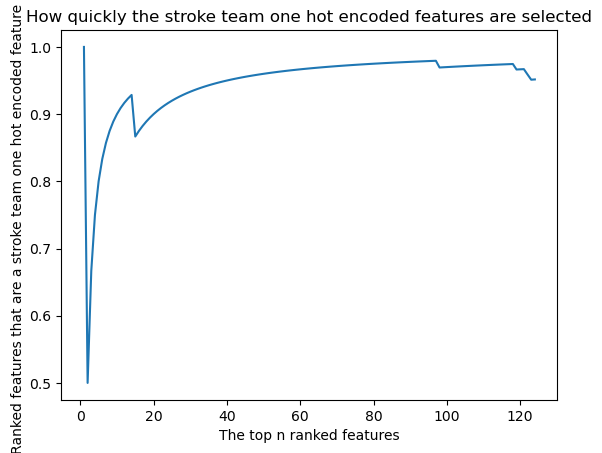

In [80]:
# Create a mask for feature names that don't contain string "team"
mask_exclude_team = ['team' not in i for i in list(df_feature_importance.index)]
mask_team = ['team' in i for i in list(df_feature_importance.index)]

list_pc_team_feature = [sum(mask_team[:i+1])/(i+1) for i in range(n_features)]

plt.plot(list(range(1, (n_features + 1),1)), list_pc_team_feature)
plt.title('How quickly the stroke team one hot encoded features are selected')
plt.xlabel('The top n ranked features')
plt.ylabel('Ranked features that are a stroke team one hot encoded feature (%)')

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_percent_team_ohe_features_ranked_importance.jpg'))
plt.savefig(filename, dpi=300)

Now show the top 15 features (in terms of importance), excluding the one hot encoded stroke team features

In [81]:
# Use a mask for feature names that don't contain string "team"
df_feature_importance[mask_exclude_team].head(15)

,0,1,2,3,4,importance (mean),importance (std dev),importance (min),importance (median),importance (max)
prior_disability,0.033415,0.033099,0.032987,0.032908,0.032566,0.032995,0.000275,0.032566,0.032987,0.033415
stroke_severity,0.013771,0.013467,0.013811,0.013832,0.013792,0.013735,0.000135,0.013467,0.013792,0.013832
age,0.004442,0.004342,0.004516,0.004437,0.004400,0.004428,0.000057,0.004342,0.004437,0.004516
onset_to_thrombolysis_time,0.003058,0.002982,0.003064,0.003069,0.003027,0.003040,0.000033,0.002982,0.003058,0.003069
precise_onset_known,0.002339,0.002297,0.002424,0.002427,0.002355,0.002368,0.000050,0.002297,0.002355,0.002427
any_afib_diagnosis,0.002224,0.002287,0.002282,0.002255,0.002290,0.002267,0.000025,0.002224,0.002282,0.002290


Create a violin plot for the top 25 features with the highest feature importance values.

Shows the distribution of the feature importance values for each feature across the 5 kfold splits (the shaded area show the density of the data points).

The same data in each plot, the right one excludes the stroke team one hot encoded features.

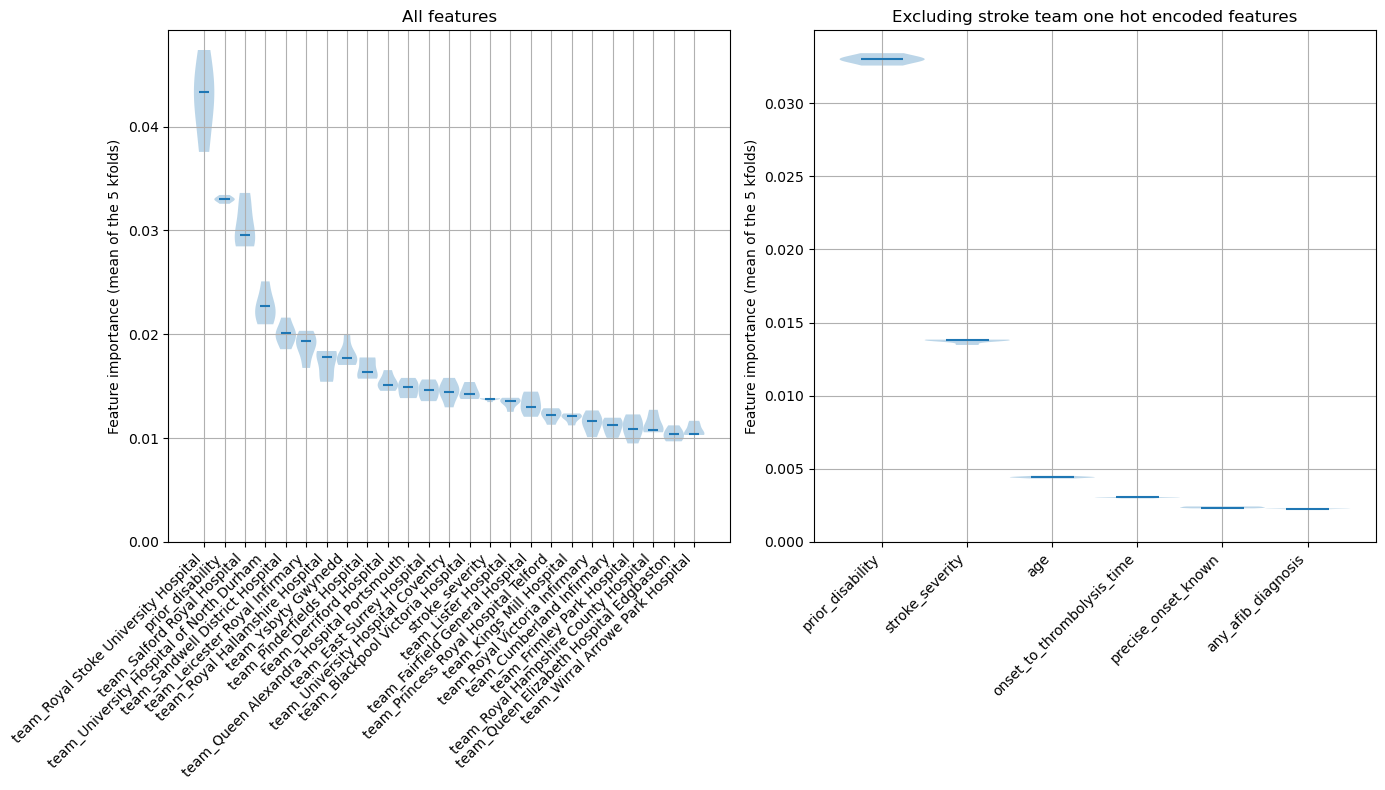

In [82]:
# Number of ranked features to show in plot
n_features_show = 25

# Set plot width based on number of features to show
width = 14 * (n_features_show/25)

# Set up figure
fig = plt.figure(figsize=(width,8))

# Create list of kfold indices
cols = [str(i) for i in range(n_kfold)]

# Set up first mask to include all features, and second mask to exclude stroke team
list_mask = [[True] * n_features, mask_exclude_team]
list_title = ['All features', 'Excluding stroke team one hot encoded features']

for subplot in range(2):
    features_show = (list(df_feature_importance[list_mask[subplot]].head(n_features_show).index))

    ax1 = fig.add_subplot(1,2,subplot+1)

    ax1.violinplot(df_feature_importance[cols].loc[features_show].T,
                   showmedians=True, widths=1, showextrema=False)
    ax1.set_ylim(0)
    ax1.set_xticks(np.arange(1, len(features_show) + 1))
    ax1.set_xticklabels(features_show, rotation=45, ha='right')
    ax1.grid(which='both')
    ax1.set_ylabel('Feature importance (mean of the 5 kfolds)')
    ax1.set_title(list_title[subplot])

plt.tight_layout()

filename = (
    os.path.join(paths.image_save_path, 
                 (paths.notebook + paths.model_text + 
                  '_importance_violin.jpg')))

plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()


## Section 1.2: SHAP values
SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance, for each of the 7 output classes. We can analyse the SHAP values in a different way than if it was a binary model.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios. A SHAP value is returned for each feature, for each instance, for each model (one per k-fold)

#### Get average SHAP values for each k-fold

For each k-fold split, calculate the mean SHAP value for each feature (across all instances), for each of the 7 disability discharge output values. 

The mean is calculated in three ways:

1. mean of raw values
2. mean of absolute values
3. absolute of mean of raw values


In a separate dataframe (df_mean_abs_shap), store the mean of the absolute SHAP values for each kfold, and also the min, median and max across the 5 kfolds (a row per feature). A dataframe per output class.

In [83]:
# Initialise dictionary. Key name is output_class. Holds a list for dataframes
# for that class (for each kfold). The dataframe has a row per feature and a 
# column for the average SHAP values across all of the instances
dict_mean_abs_shap = {}
dict_list_of_df = {}

# For each output class
for c in range(n_classes):

    ## Initialise empty lists
    shap_values_mean_kfold = []
    # Initialise DataFrame (stores mean of the absolute SHAP values for each kfold)
    df_mean_abs_shap = pd.DataFrame()

    # For each k-fold split
    for k in range(n_kfold):
        # Calculate mean SHAP value for each feature (across all instances), for
        # this class
        shap_values = shap_values_kfold[k][:,:,c]
        df = pd.DataFrame(index=features_ohe)
        df['mean_shap'] = np.mean(shap_values, axis=0)
        df['abs_mean_shap'] = np.abs(df['mean_shap'])
        df['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
        df['rank'] = df['mean_abs_shap'].rank(ascending=False).values
        df.sort_index()
        shap_values_mean_kfold.append(df)

        # Store the mean of the absolute SHAP values in a dataframe (column for 
        # each k-fold split). 
        # Add more columns to this dataframe
        df_mean_abs_shap[f'{k}'] = df['mean_abs_shap']

    # For this class, df_mean_abs_shap has a column per kfold, row per feature, 
    # stores the mean of the absolute SHAP values across all instances.
    # Dictionary has a keyname per class, each storing a list of dataframes 
    # (a dataframe per kfold)
    dict_list_of_df[f'class{c}'] = shap_values_mean_kfold

    # Dictionary has a keyname per class, each storing a dataframe with a column 
    # per kfold (the mean of the absolute SHAPS across the instances). 

    # Create list of kfold indices
    cols = [str(i) for i in range(n_kfold)]
    
    df_mean_abs_shap['min'] = df_mean_abs_shap[cols].min(axis=1)
    df_mean_abs_shap['median'] = df_mean_abs_shap[cols].median(axis=1) 
    df_mean_abs_shap['max'] = df_mean_abs_shap[cols].max(axis=1)
    # Order features by their median value of the mean across the instances of their absolute SHAP
    df_mean_abs_shap.sort_values('median', inplace=True, ascending=False)


    # The 3 columns (min, median, max) that were in df_mean_abs_shap_summary are now in df_mean_abs_shap
    # Store the dataframe for this class (row per feature, column per kfold (and summary statistics) for SHAPs across all instances)
    dict_mean_abs_shap[f'class{c}'] = df_mean_abs_shap

For each output class, identify the 15 features with the highest SHAP values (in terms of the median of the kfolds of the mean of the absolute SHAP values) and create a violin plot.

Violin plots show the distribution of the shap values for each feature across the 5 kfold splits (the shaded area show the density of the data points).

The same data in each plot, the right one excludes the stroke team one hot encoded features.

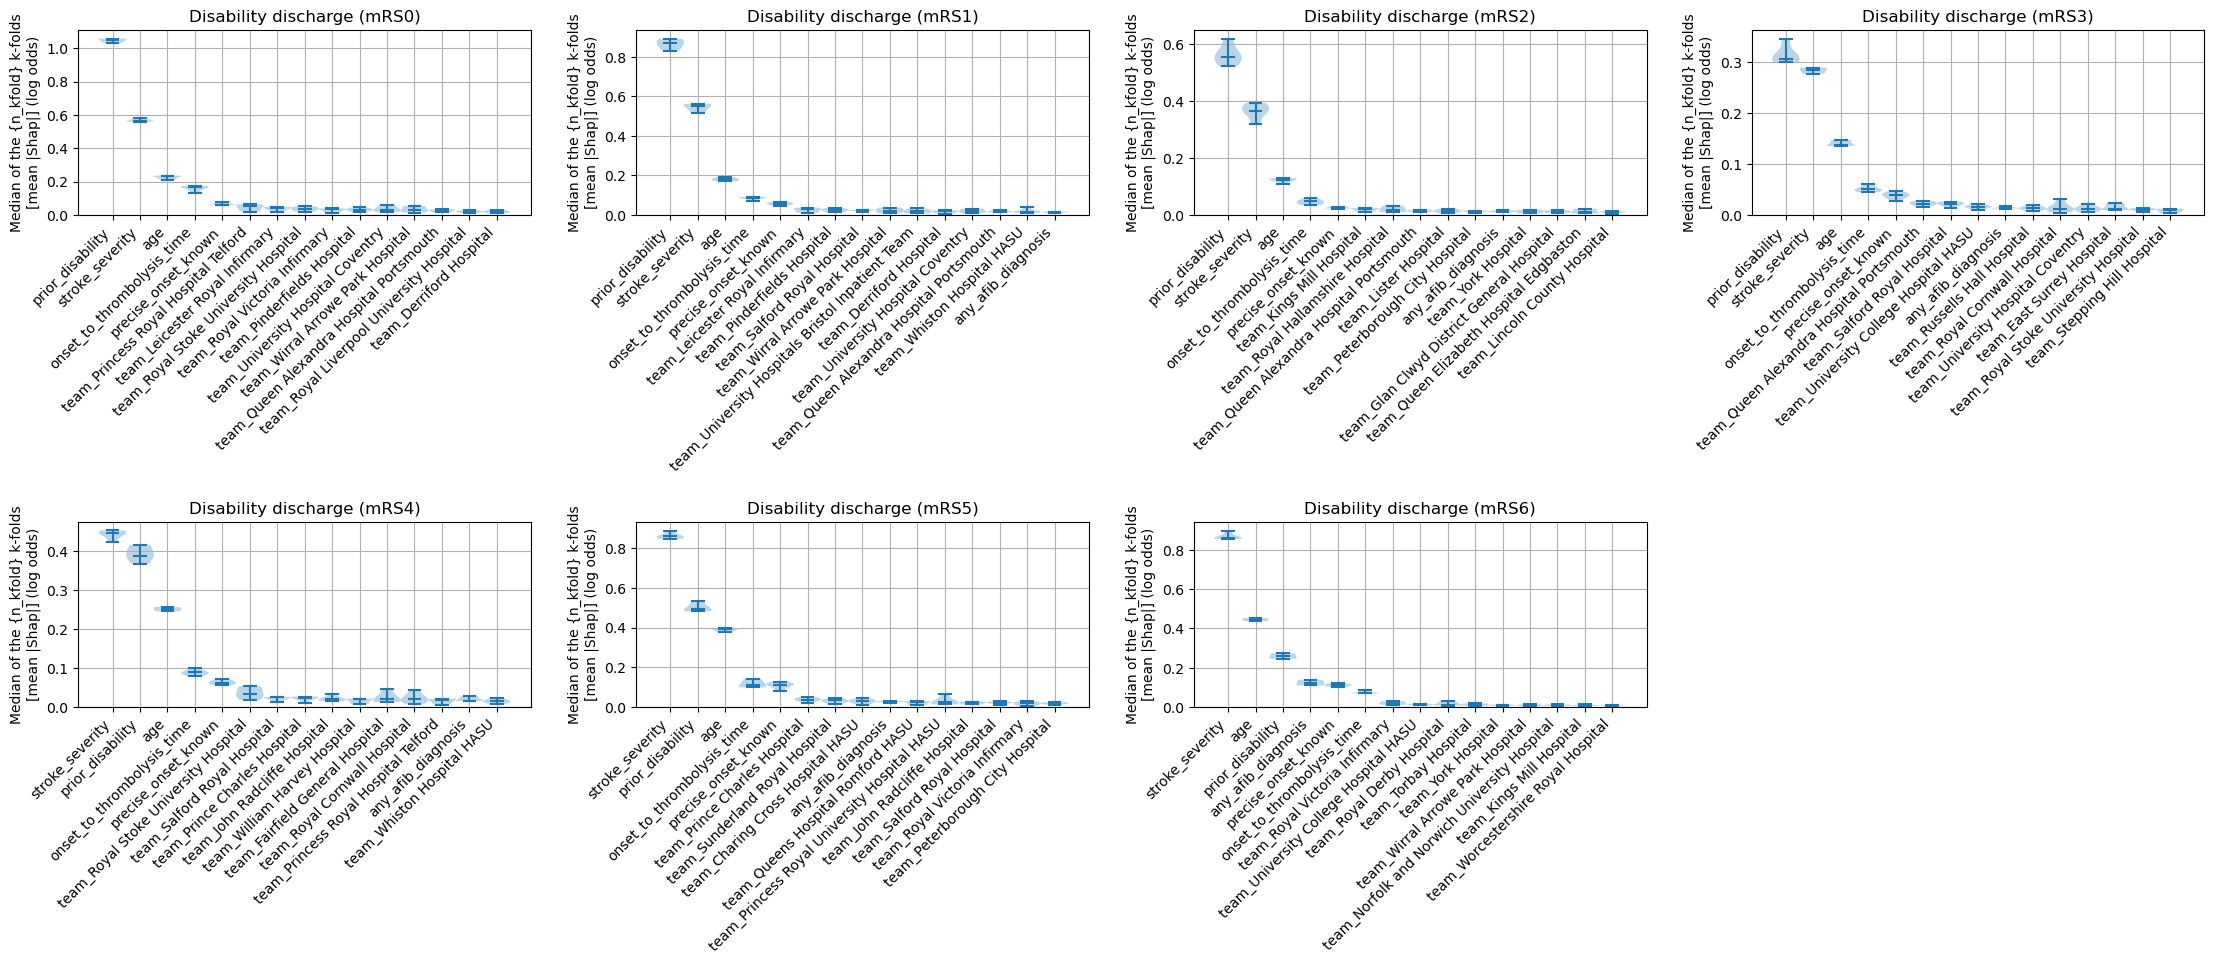

In [84]:
n_features_show = 15

width = 15 * (n_features_show/10)

fig = plt.figure(figsize=(width, 10))

for c in range(n_classes):
    # Data for the violin plot (for this class)
    df_mean_abs_shap = dict_mean_abs_shap[f'class{c}']

    # Create list of kfold indices
    cols = [str(i) for i in range(n_kfold)]
               
    ax1 = fig.add_subplot(2,4,c+1)
    ax1.violinplot(df_mean_abs_shap[cols].iloc[:n_features_show].T,
                   showmedians=True, widths=1)
    ax1.set_ylim(0)
    ax1.set_title(f'Disability discharge (mRS{c})')
    labels = df_mean_abs_shap.index[:n_features_show]
    ax1.set_xticks(np.arange(1, len(labels) + 1))
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.grid(which='both')
    ax1.set_ylabel('Median of the {n_kfold} k-folds\n[mean |Shap|] (log odds)')

plt.subplots_adjust(bottom=0.25, wspace=0.05)
    
plt.tight_layout(pad=2)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + '_shap_violin.jpg'))

plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

Surprised that the one hot encoded stroke team features are not dominating the ranked list (as in the feature importance)

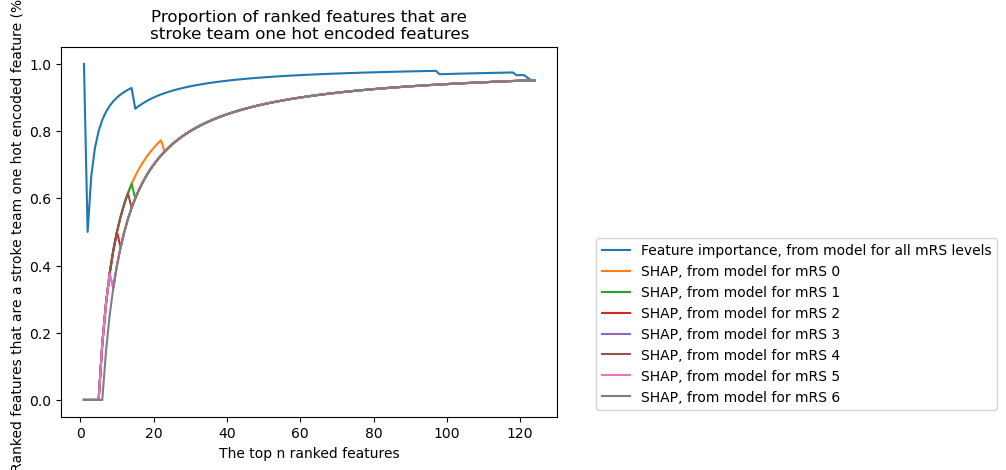

In [85]:
# Create list of kfold indices
cols = [str(i) for i in range(n_kfold)]

#for c in range(n_classes):

plt.plot(list(range(1, (n_features + 1),1)), list_pc_team_feature, 
         label="Feature importance, from model for all mRS levels")

for c in range(n_classes):

    # Data for the violin plot (for this class)
    df_mean_abs_shap = dict_mean_abs_shap[f'class{c}']

    # Create a mask for feature names that don't contain string "team"
    mask_exclude_team_features_shap = (
                ['team' not in i for i in list(df_mean_abs_shap.index.values)])
    mask_team_features_shap = (
                ['team' in i for i in list(df_mean_abs_shap.index.values)])

    list_pc_team_feature_shap = (
        [sum(mask_team_features_shap[:i+1])/(i+1) for i in range(n_features)])

    plt.plot(list(range(1, (n_features + 1),1)), 
             list_pc_team_feature_shap, label=f"SHAP, from model for mRS {c}")
#plt.xlim((0,10))
plt.title('Proportion of ranked features that are\nstroke team one hot encoded features')
plt.xlabel('The top n ranked features')
plt.ylabel('Ranked features that are a stroke team one hot encoded feature (%)')
plt.legend(loc="lower right", bbox_to_anchor=(1.9, 0))
filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_percent_team_ohe_features_ranked_importance.jpg'))
plt.savefig(filename, dpi=300)

## Section 1.3: Compare top 10 SHAP and feature importance values

Compare the features (and their values) that make the top 10 when selected by either SHAP values, or feature importance values.

In [86]:
df_compare_shap_importance = pd.DataFrame()
df_compare_shap_importance['Importance (feature name)'] = \
                            df_feature_importance.index
df_compare_shap_importance['Importance (median value)'] = \
                            df_feature_importance['importance (median)'].values

for c in range(n_classes):
    # Data for the violin plot (for this class)
    df_compare_shap_importance[f'SHAP (feature name) [mRS{c}]'] = (
                            dict_mean_abs_shap[f'class{c}'].index)
    df_compare_shap_importance[f'SHAP (median value) [mRS{c}]'] = (
                            dict_mean_abs_shap[f'class{c}']['median'].values)
               
df_compare_shap_importance.head(10)

,Importance (feature name),Importance (median value),SHAP (feature name) [mRS0],SHAP (median value) [mRS0],SHAP (feature name) [mRS1],SHAP (median value) [mRS1],SHAP (feature name) [mRS2],SHAP (median value) [mRS2],SHAP (feature name) [mRS3],SHAP (median value) [mRS3],SHAP (feature name) [mRS4],SHAP (median value) [mRS4],SHAP (feature name) [mRS5],SHAP (median value) [mRS5],SHAP (feature name) [mRS6],SHAP (median value) [mRS6]
0,team_Royal Stoke University Hospital,0.043326,prior_disability,1.049177,prior_disability,0.868601,prior_disability,0.552984,prior_disability,0.305984,stroke_severity,0.445686,stroke_severity,0.859365,stroke_severity,0.859911
1,prior_disability,0.032987,stroke_severity,0.564526,stroke_severity,0.552741,stroke_severity,0.365547,stroke_severity,0.284242,prior_disability,0.387454,prior_disability,0.491023,age,0.446961
2,team_Salford Royal Hospital,0.029576,age,0.230635,age,0.180015,age,0.122397,age,0.137607,age,0.250892,age,0.391439,prior_disability,0.256851
3,team_University Hospital of North Durham,0.022759,onset_to_thrombolysis_time,0.165433,onset_to_thrombolysis_time,0.087594,onset_to_thrombolysis_time,0.047676,onset_to_thrombolysis_time,0.050735,onset_to_thrombolysis_time,0.088481,onset_to_thrombolysis_time,0.111258,any_afib_diagnosis,0.122131
4,team_Sandwell District Hospital,0.020148,precise_onset_known,0.060913,precise_onset_known,0.056611,precise_onset_known,0.023568,precise_onset_known,0.039317,precise_onset_known,0.062133,precise_onset_known,0.109621,precise_onset_known,0.110727
5,team_Leicester Royal Infirmary,0.019310,team_Princess Royal Hospital Telford,0.051018,team_Leicester Royal Infirmary,0.028114,team_Kings Mill Hospital,0.021030,team_Queen Alexandra Hospital Portsmouth,0.022219,team_Royal Stoke University Hospital,0.032785,team_Prince Charles Hospital,0.035460,onset_to_thrombolysis_time,0.070244
6,team_Royal Hallamshire Hospital,0.017819,team_Leicester Royal Infirmary,0.042969,team_Pinderfields Hospital,0.024943,team_Royal Hallamshire Hospital,0.018355,team_Salford Royal Hospital,0.021668,team_Salford Royal Hospital,0.025129,team_Sunderland Royal Hospital,0.031807,team_Royal Victoria Infirmary,0.017398
7,team_Ysbyty Gwynedd,0.017711,team_Royal Stoke University Hospital,0.036598,team_Salford Royal Hospital,0.023524,team_Queen Alexandra Hospital Portsmouth,0.013212,team_University College Hospital HASU,0.015369,team_Prince Charles Hospital,0.022583,team_Charing Cross Hospital HASU,0.029735,team_University College Hospital HASU,0.011320
8,team_Pinderfields Hospital,0.016385,team_Royal Victoria Infirmary,0.035260,team_Wirral Arrowe Park Hospital,0.022038,team_Lister Hospital,0.013172,any_afib_diagnosis,0.012924,team_John Radcliffe Hospital,0.019928,any_afib_diagnosis,0.025792,team_Royal Derby Hospital,0.011259
9,team_Derriford Hospital,0.015163,team_Pinderfields Hospital,0.029405,team_University Hospitals Bristol Inpatient Team,0.020332,team_Peterborough City Hospital,0.012314,team_Russells Hall Hospital,0.012825,team_William Harvey Hospital,0.019368,team_Queens Hospital Romford HASU,0.024629,team_Torbay Hospital,0.010967


Plot all of the features, showing feature importance vs SHAP values.

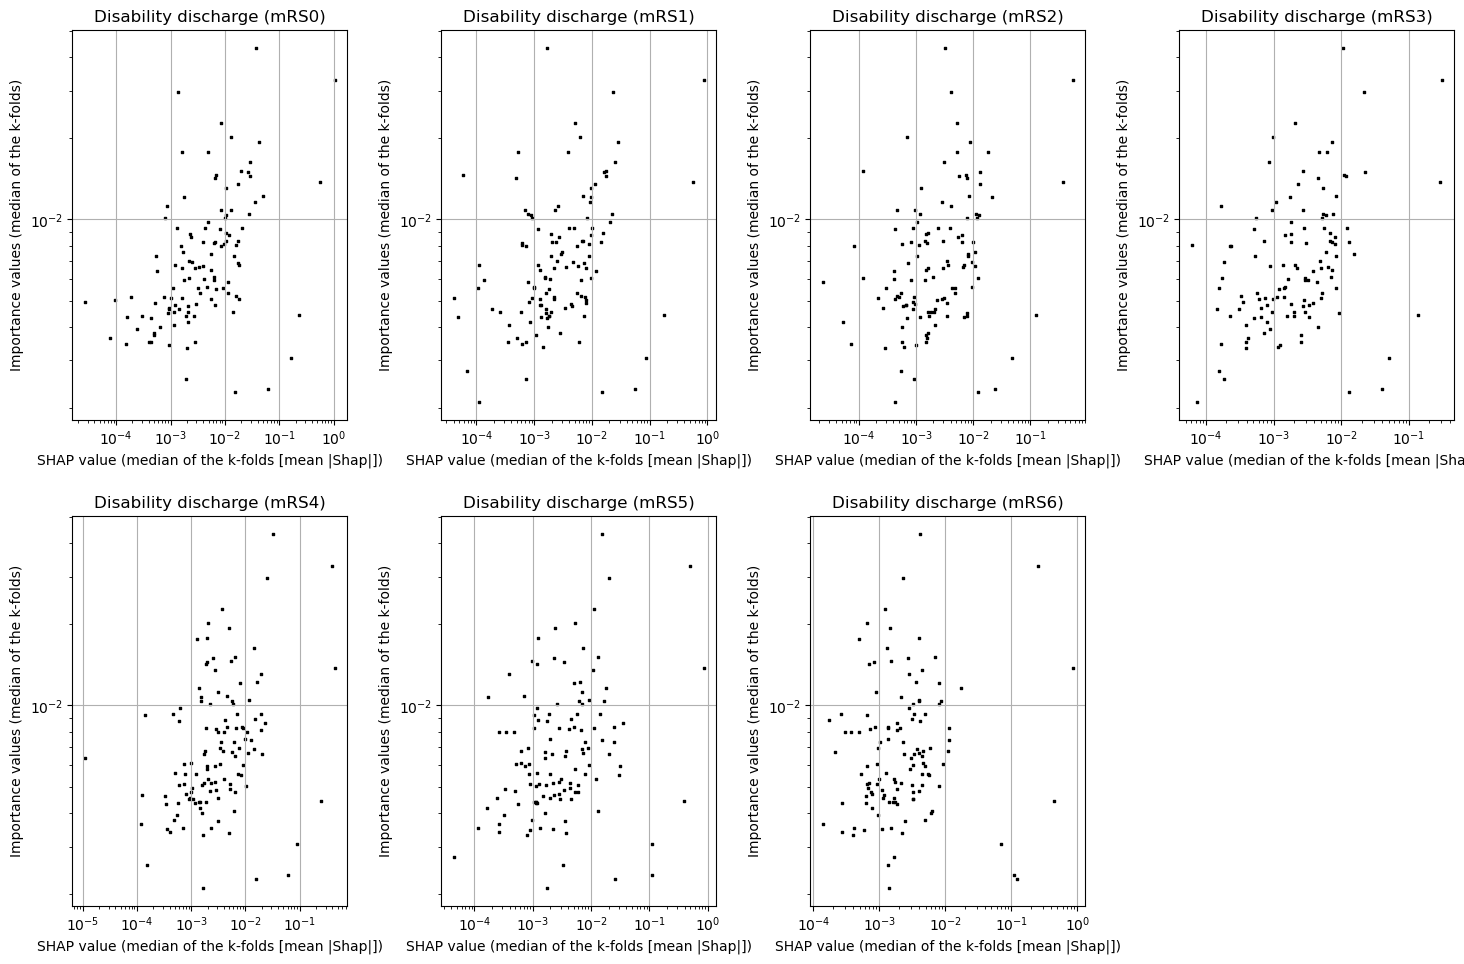

In [87]:
fig = plt.figure(figsize=(15, 10))

for c in range(n_classes):
    # Data for the violin plot (for this class)
    df_mean_abs_shap = dict_mean_abs_shap[f'class{c}']
    

    df_shap_importance = pd.DataFrame()
    df_shap_importance['Shap'] =  df_mean_abs_shap['median']
    df_shap_importance = df_shap_importance.merge(
                        df_feature_importance['importance (median)'], 
                        left_index=True, right_index=True)
    df_shap_importance.rename(columns={'importance (median)': 'Importance'}, 
                              inplace=True)
    df_shap_importance.sort_values('Shap', inplace=True, ascending=False)

    ax1 = fig.add_subplot(2,4,c+1)
    ax1.scatter(df_shap_importance['Shap'], df_shap_importance['Importance'], 
                c='k', marker='s', s=1)
    ax1.set_title(f'Disability discharge (mRS{c})')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('SHAP value (median of the k-folds [mean |Shap|])')
    ax1.set_ylabel('Importance values (median of the k-folds)')
    ax1.grid()

plt.subplots_adjust(bottom=0.25, wspace=0.05)

plt.tight_layout(pad=2)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_shap_importance_correlation.jpg'))

plt.savefig(filename, dpi=300)
plt.show()


Show summary SHAP plot for each kfold.

Shows the mean absolute SHAP for each feature for each class output.

Show summary SHAP plot for each kfold.

Shows the mean absolute SHAP for each feature for each class output.

Need to reformat the SHAP values (as they contain multiclass output) into a list, with the SHAP value array for each class as a separate element in the list. Otherwise, if we pass the 3D array (instance, feature, class) to shap.summary_plot, the function will assume that the 3D array contains shap interaction values. For our case the 3D array is of size (33670, 177, 7). It will create a grid of plots of each pair-wise combination of the first 7 features, and treat the values as SHAP interactions.

We instead want to have a list of length 7 (the last array dimension), an array in the list per class.

```
shap.summary_plot(shap_values_kfold[k], X_test.values, plot_type="bar", 
                class_names= class_names, feature_names = X_test.columns, 
                show=False, plot_size=(6,6), title=f"k-fold {k+1}")
```

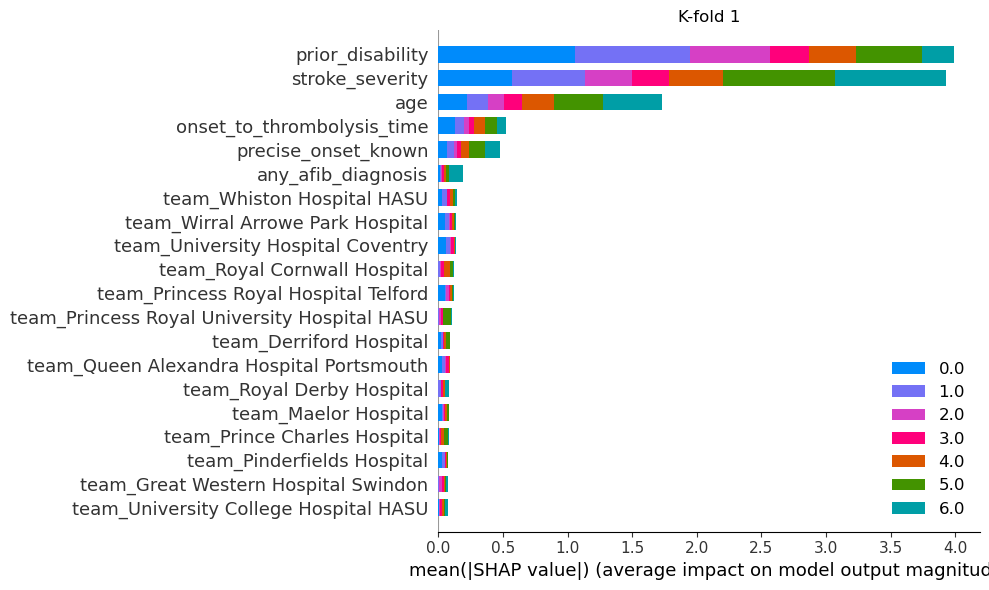

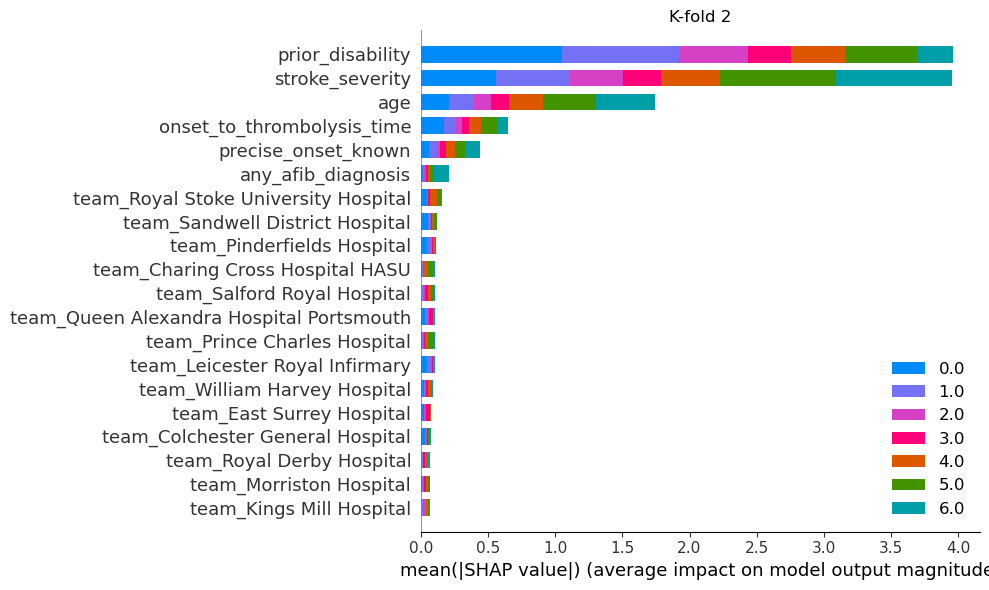

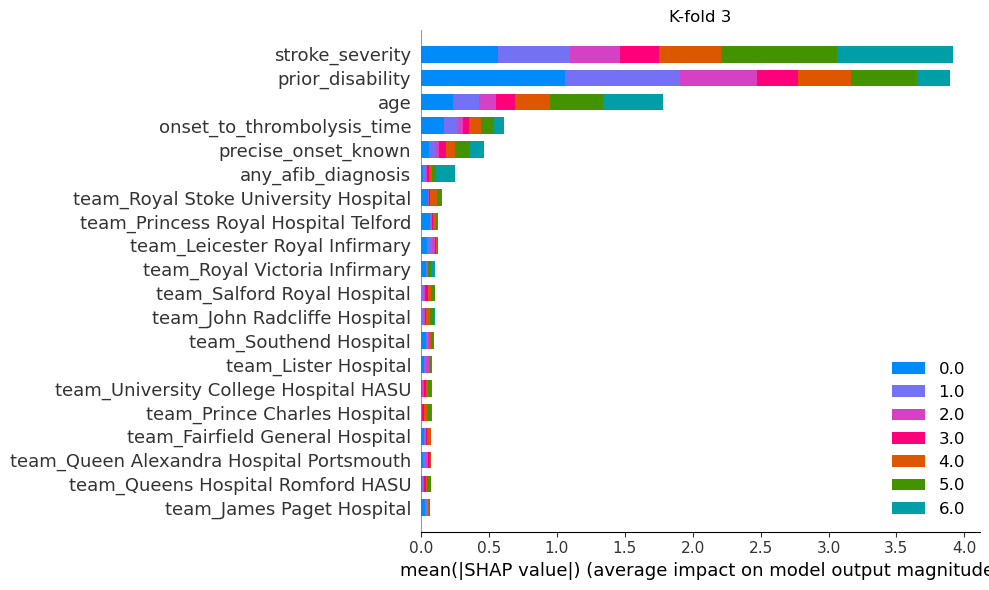

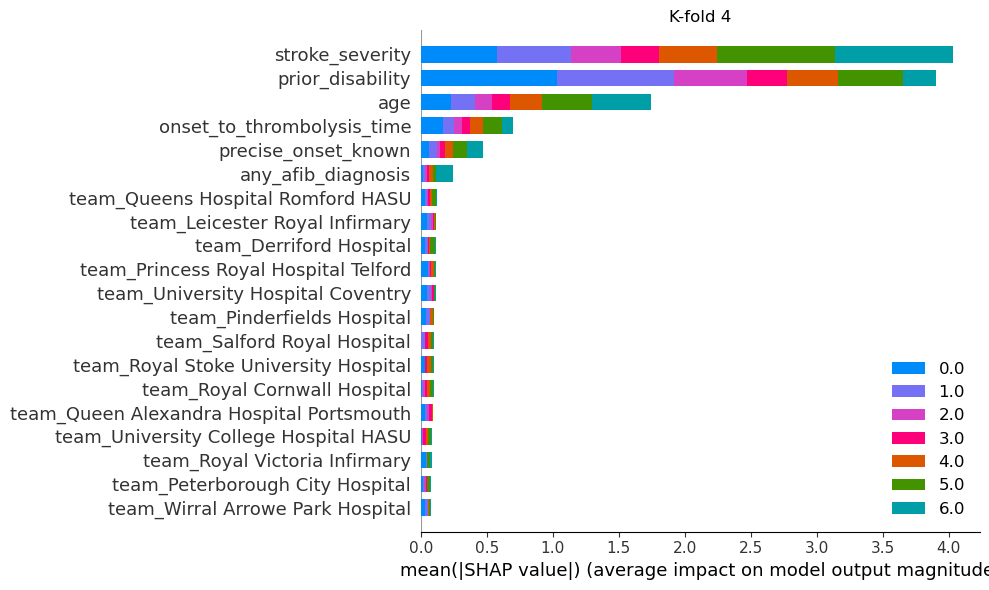

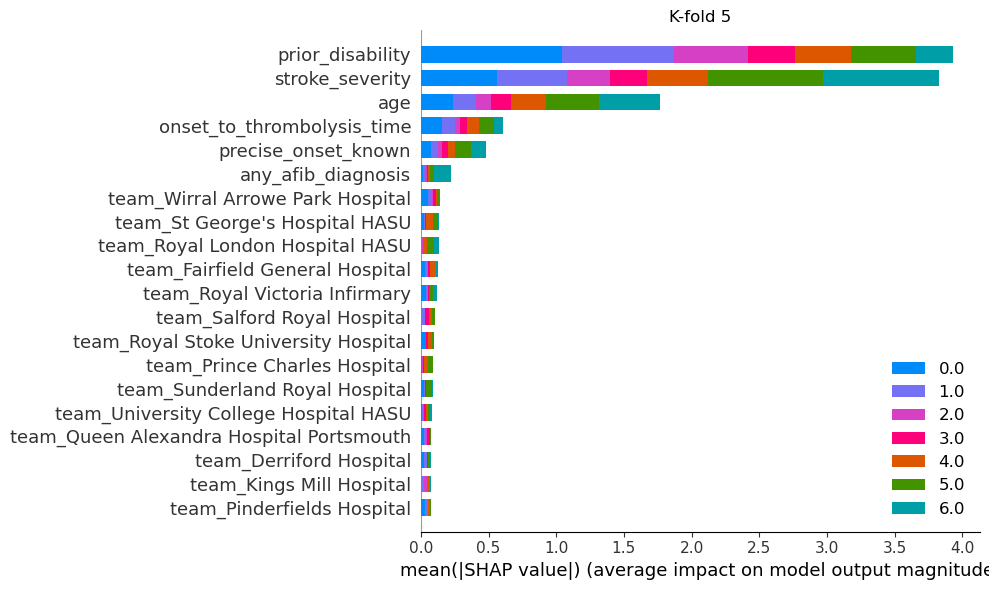

In [88]:
for k in range(n_kfold):
    # Initialise empty list
    shap_values_list = []

    # Putting the SHAP values in the required format
    for c in range(n_classes):
        shap_values_list.append(shap_values_kfold[k][:,:,c])

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')

    # Plot a SHAP summary plot, one for each k-fold
    shap.summary_plot(shap_values_list, X_test.values, plot_type="bar", 
                      class_names=model.classes_, 
                      feature_names = X_test.columns, class_inds="original",
                      show=False, plot_size=(10,6))

    plt.title(f"K-fold {k+1}")
    plt.tight_layout()

    filename = os.path.join(paths.image_save_path, 
                            (paths.notebook + paths.model_text + 
                            f'_shap_summary_plot_all_classes_kfold{k}.jpg'))

    plt.savefig(filename, dpi=300)
    
    plt.show()

You can also see the summary_plot of a specific class.

First look at one class in each k-fold (see they are very similar, so next look at just the first kfold for each class)
```
shap_values_kfold[kfold][instance, feature, class]
```

Can choose to display as violin plots.

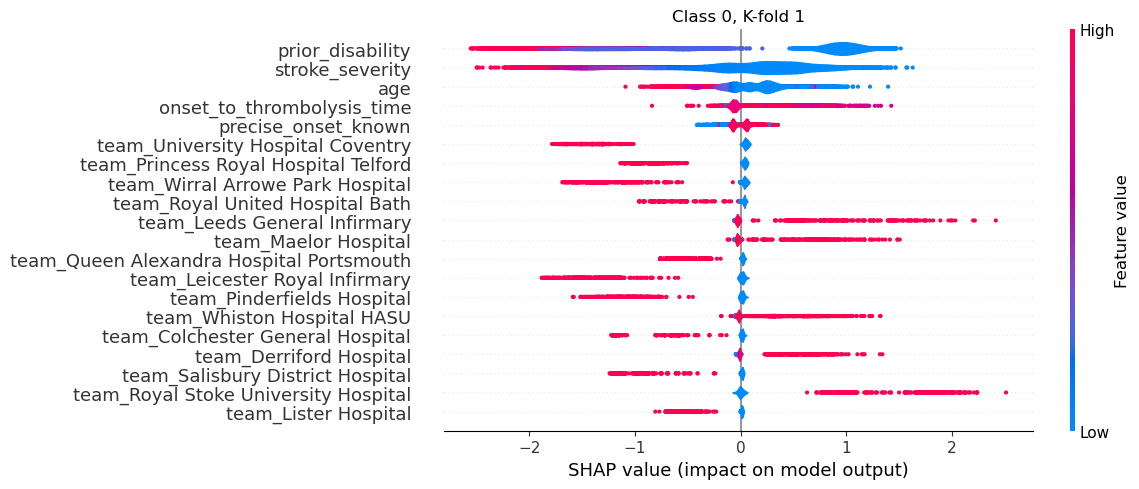

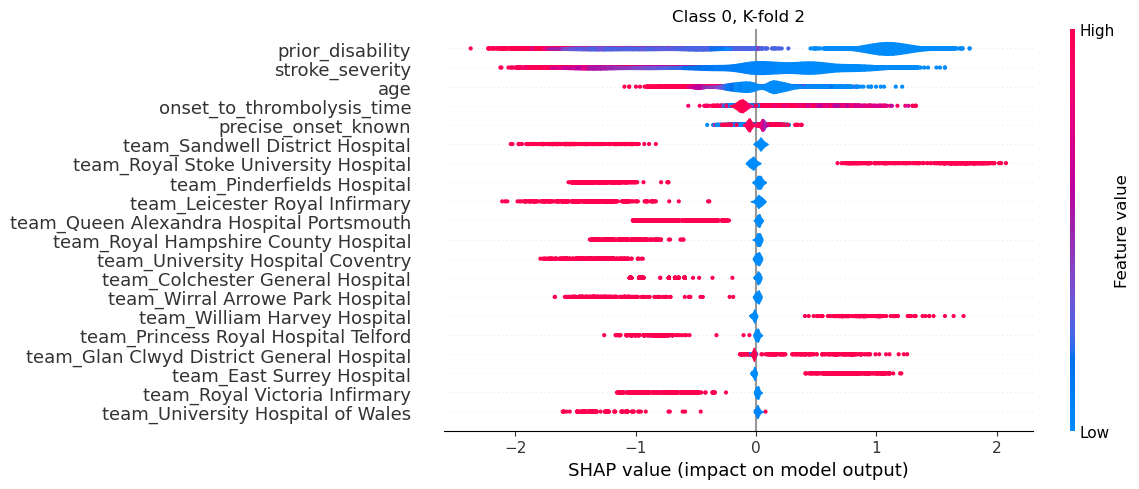

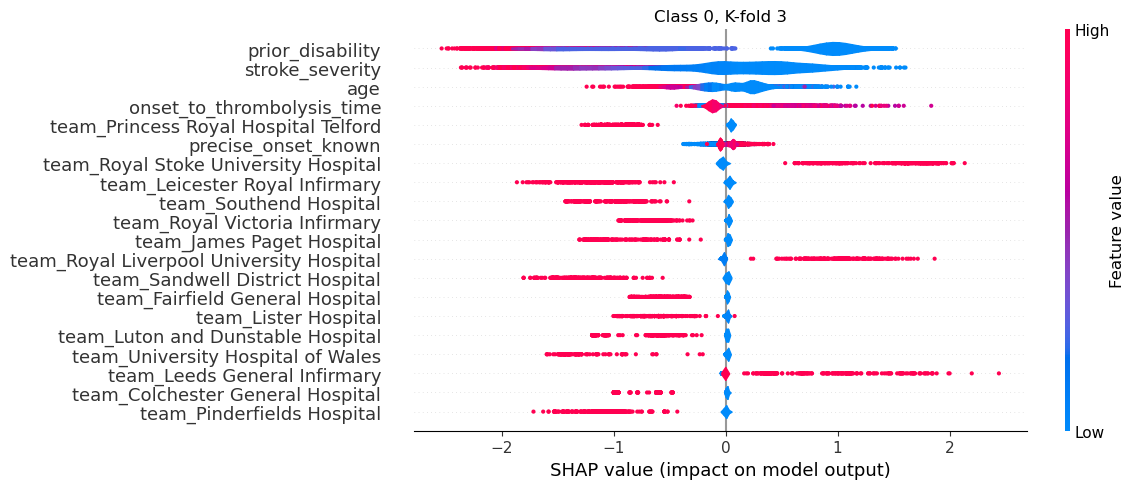

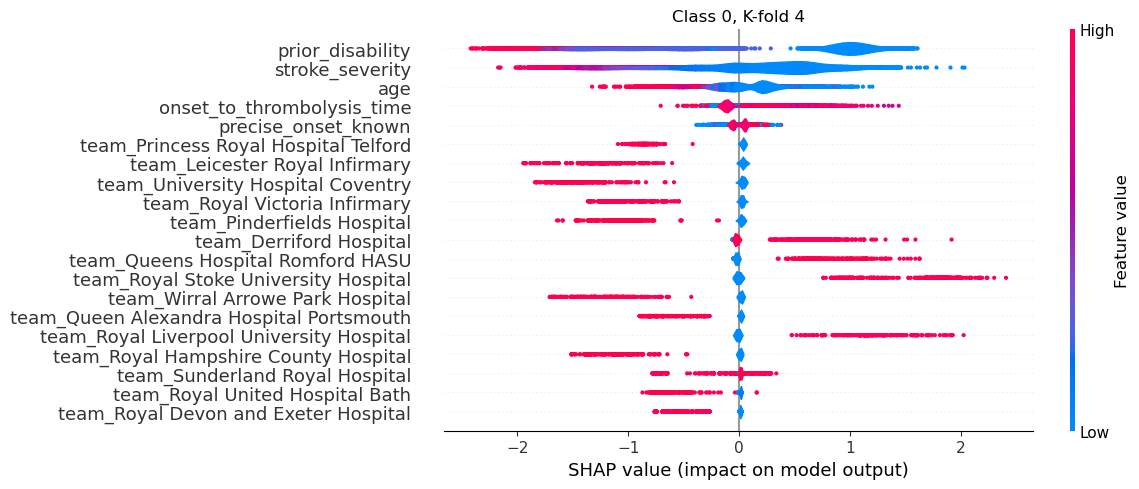

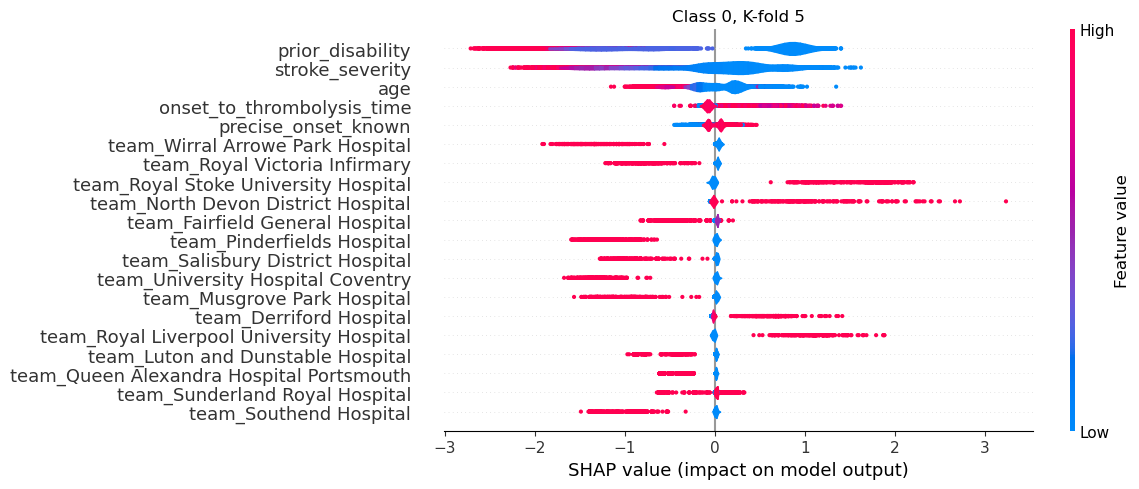

In [89]:
c = 0
c_index = np.where(class_names == c)[0][0]

for k in range(5):
    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                    test_data_kfold[k],
                                                    'discharge_disability')

    shap.summary_plot(shap_values_kfold[k][:,:,c_index], X_test.values, 
                    feature_names=X_test.columns, show=False, 
                    plot_size=(12,5), plot_type='violin')

    plt.title(f"Class {c}, K-fold {k+1}")
    plt.tight_layout()

    filename = os.path.join(paths.image_save_path, 
                            (paths.notebook + paths.model_text + 
                            f'_shap_summary_plot_mrs{c}_kfold{k}.jpg'))

    plt.savefig(filename, dpi=300)

    plt.show()

See they are very similar, so next look at just the first kfold for each class

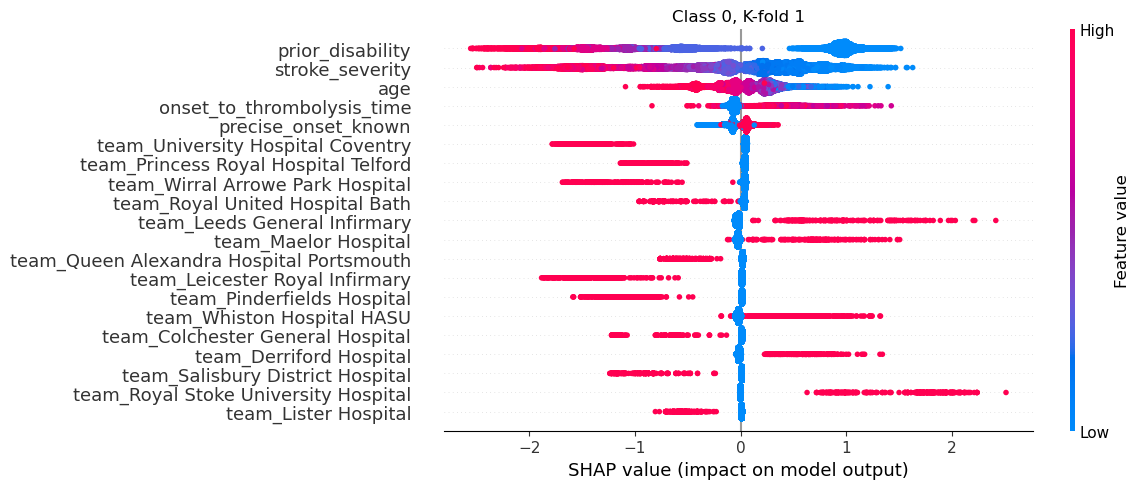

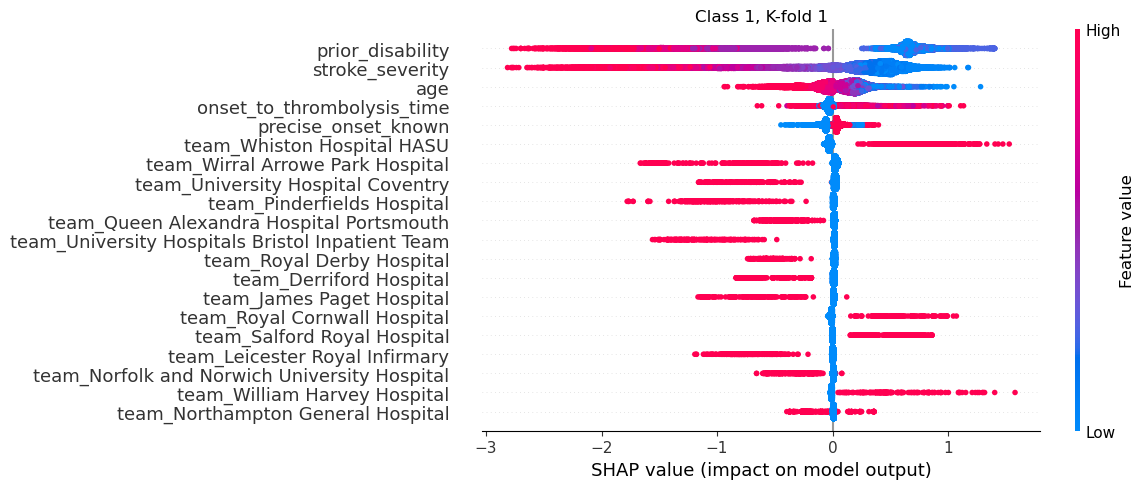

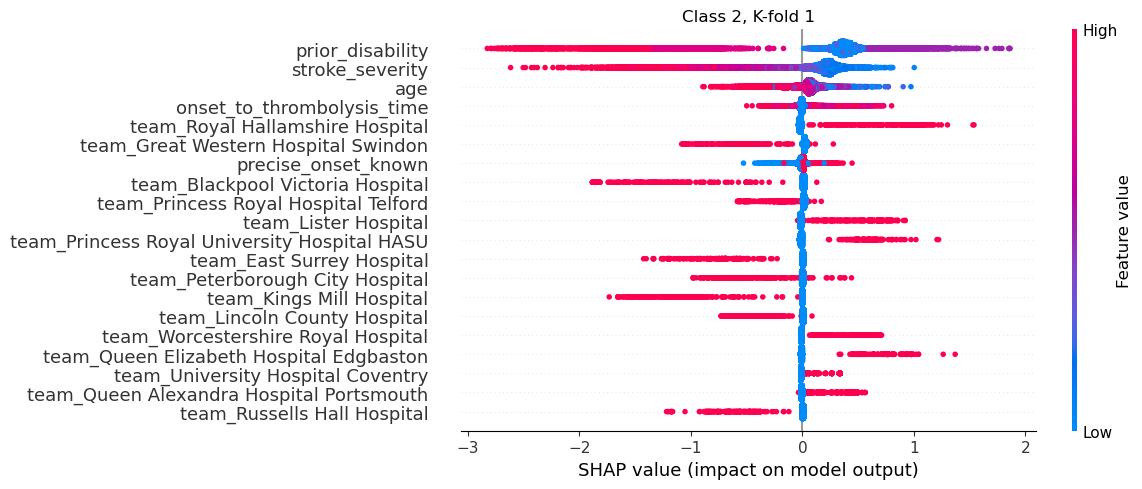

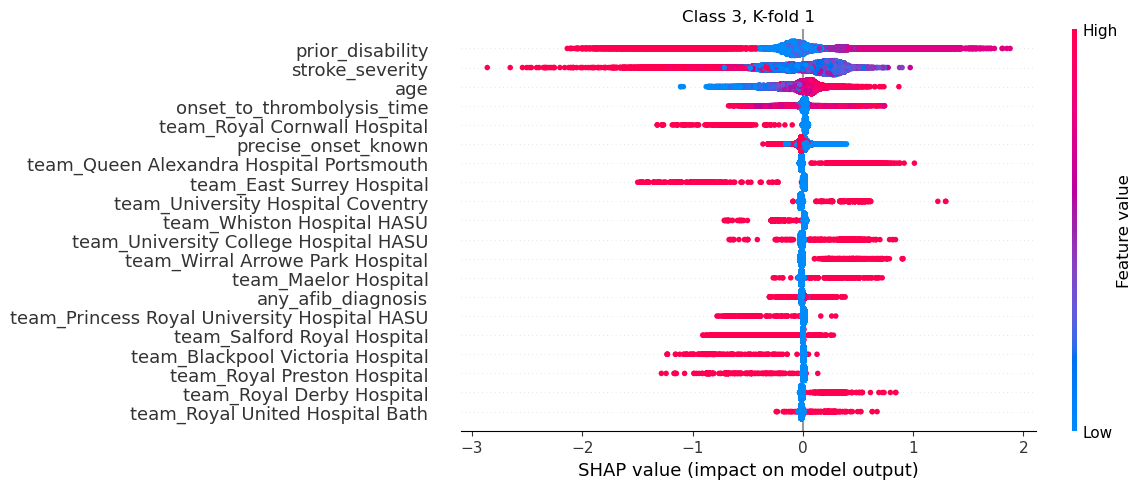

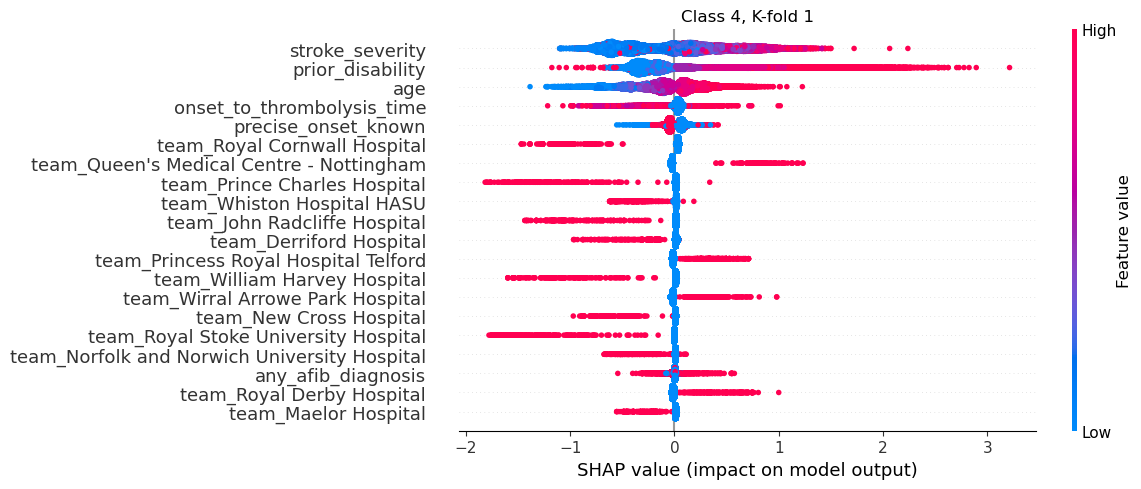

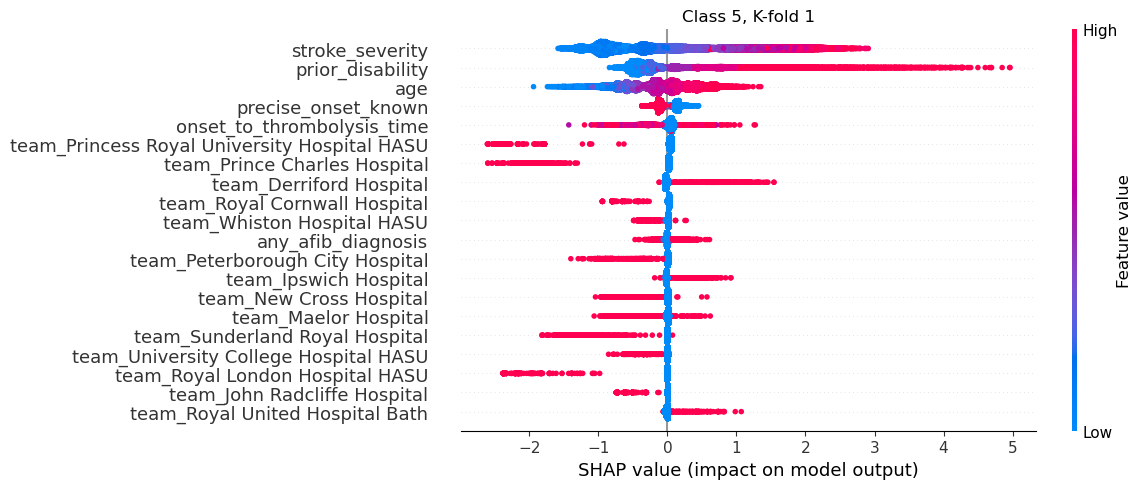

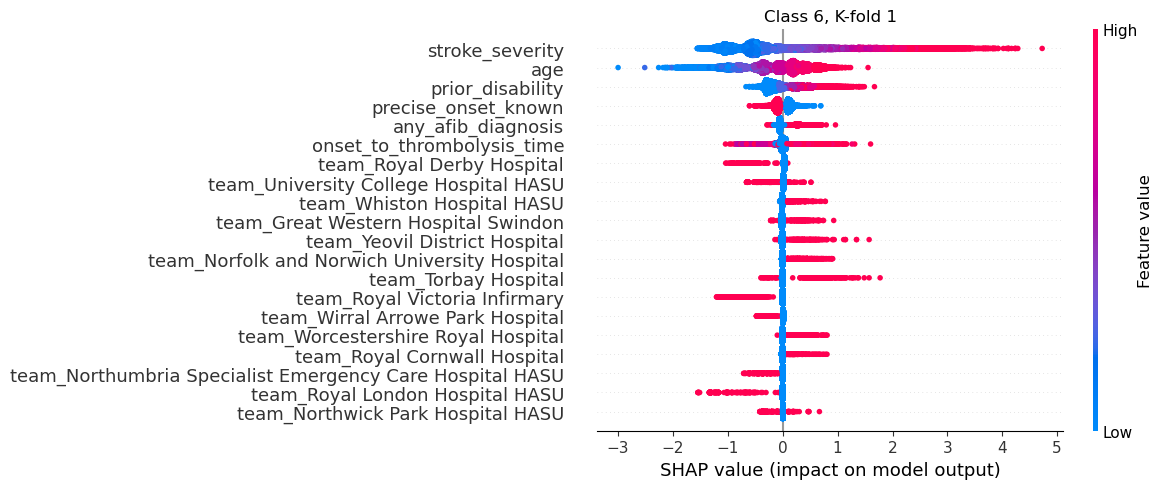

In [90]:
k = 0
# Get k fold split
(X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                test_data_kfold[k],
                                                'discharge_disability')
for c in range(len(class_names)):

    c_index = np.where(class_names == c)[0][0]

    shap.summary_plot(shap_values_kfold[k][:,:,c_index], X_test.values, 
                    feature_names=X_test.columns, show=False, 
                    plot_size=(12,5))

    plt.title(f"Class {c}, K-fold {k+1}")
    plt.tight_layout()

    filename = os.path.join(paths.image_save_path, 
                            (paths.notebook + paths.model_text + 
                            f'_shap_summary_plot_mrs{c}_kfold{k}.jpg'))

    plt.savefig(filename, dpi=300)

    plt.show()

Duration to run notebook

In [91]:
str(datetime.timedelta(seconds=(time.time()-start_time)))

'0:01:05.892624'